#### PROJECT GOAL: THE GOAL OF THE PROJECT IS TO TEST THE DEGREE OF EFFECTIVENESS OF ARTIFICIAL NEURAL NETWORK TO PREDICT VALUE OF "GENRE" FEATURE FOR MULTI-CLASS CLASSIFICATION KAGGLE CASE

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
import librosa
import librosa.display
import os

from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

#### LOADING DATA_TRAIN AND DATA_TEST

In [61]:
data_train = pd.read_csv("C:/Users/Uzytkownik/Desktop/Kaggle competitions/Music Classification/train.csv")
data_test = pd.read_csv("C:/Users/Uzytkownik/Desktop/Kaggle competitions/Music Classification/test.csv")

#### PRINTING DATA_TRAIN

In [62]:
data_train

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock
...,...,...,...,...,...
19917,9337,009337.ogg,train/009337.ogg,0,Electronic
19918,8340,008340.ogg,train/008340.ogg,4,Hip-Hop
19919,16248,016248.ogg,train/016248.ogg,4,Hip-Hop
19920,11875,011875.ogg,train/011875.ogg,2,Punk


#### CHECKING FOR DUPLICATES IN DATA_TRAIN AND DATA_TEST

In [63]:
amount_duplicated_values_train = data_train.duplicated().sum()
amount_duplicated_values_test = data_test.duplicated().sum()

percentage_duplicated_values_train = amount_duplicated_values_train/len(data_train)
percentage_duplicated_values_test = amount_duplicated_values_test/len(data_test)

print("Amount of duplicated observations in train dataset: {}".format(amount_duplicated_values_train))
print("Amount of duplicated observations in test dataset: {}".format(amount_duplicated_values_test))

print("% of duplicated observations in train dataset: {}".format(percentage_duplicated_values_train))
print("% of duplicated observations in test dataset: {}".format(percentage_duplicated_values_test))

Amount of duplicated observations in train dataset: 0
Amount of duplicated observations in test dataset: 0
% of duplicated observations in train dataset: 0.0
% of duplicated observations in test dataset: 0.0


#### DEFINING FUNCTION TO CHECK FOR MISSING VALUES

In [64]:
def Percentage_Missing_Values(df, missing_data_treshold):
    
    features_to_drop = []
            
    if df.isnull().sum().sum() != 0:
        
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
                      
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        
        f, ax = plt.subplots(figsize=(15, 12))
        plt.xticks(rotation='vertical')
        sns.barplot(x=na_df.index, y=na_df)
        
        ax.bar_label(ax.containers[0], fontsize=10, labels= round(na_df, 2))
        
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)
        
        for missing_index, missing_value in zip(missing_data['Missing Ratio %'].index, missing_data['Missing Ratio %'].values):
            if missing_value > missing_data_treshold:
                features_to_drop.append(missing_index)
                        
        return features_to_drop
        
    else:
        print('No NAs found')

#### PRINTING MISSING VALUES FOR DATA_TRAIN

In [65]:
Percentage_Missing_Values(data_train, 10)

No NAs found


#### PRINTING MISSING VALUES FOR DATA_TEST

In [66]:
Percentage_Missing_Values(data_test, 10)

No NAs found


#### PLOTTING BAR PLOT AND PIE PLOT OF 'GENRE' FEATURE DISTRIBUTION

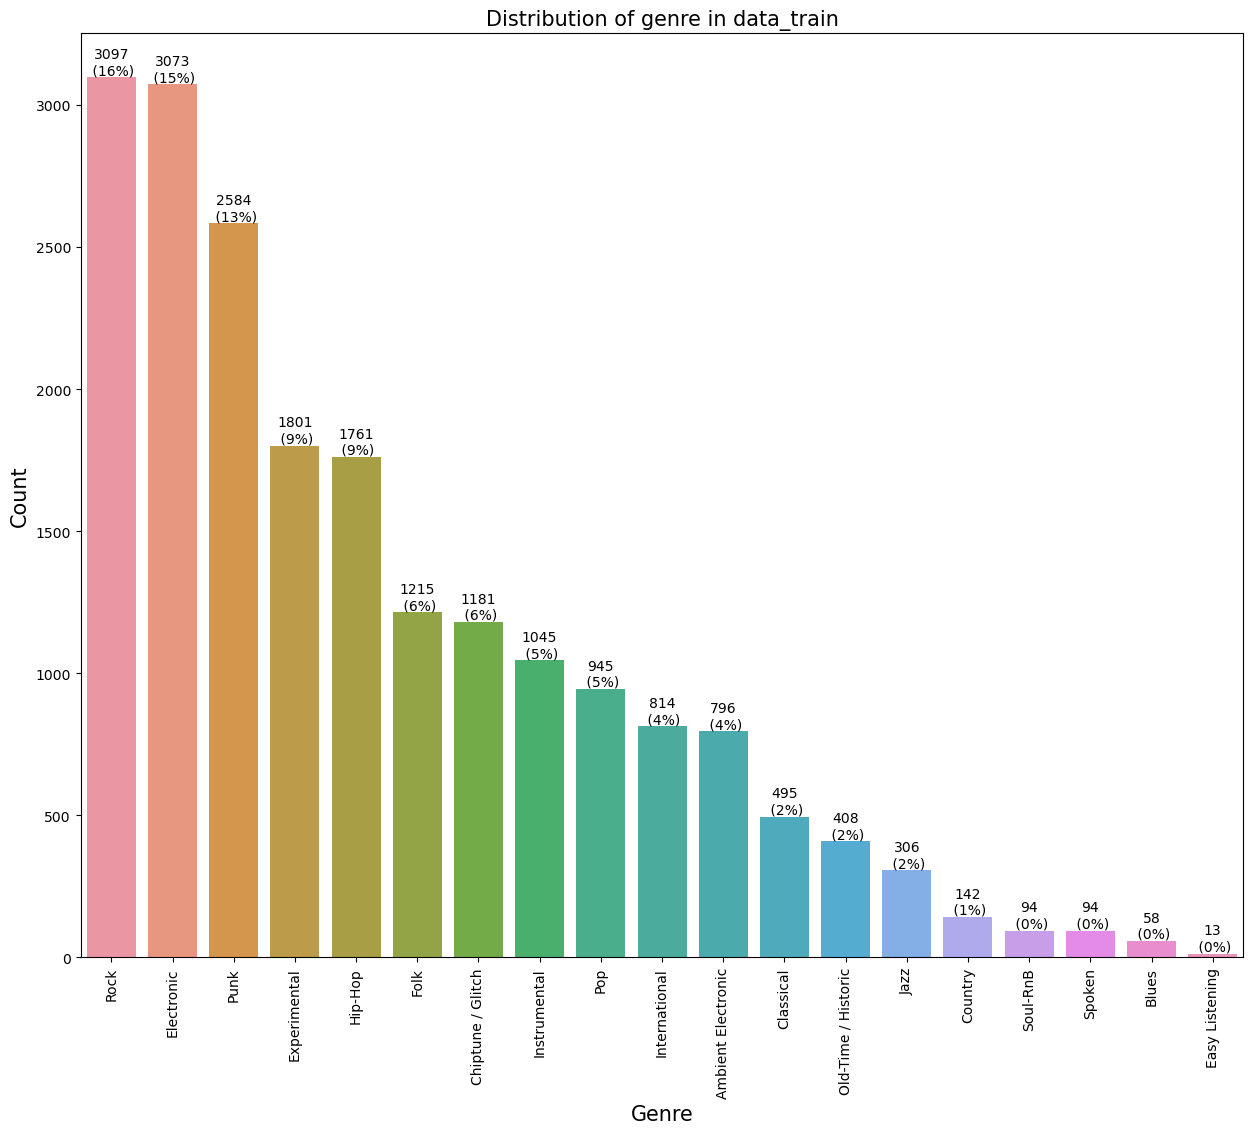

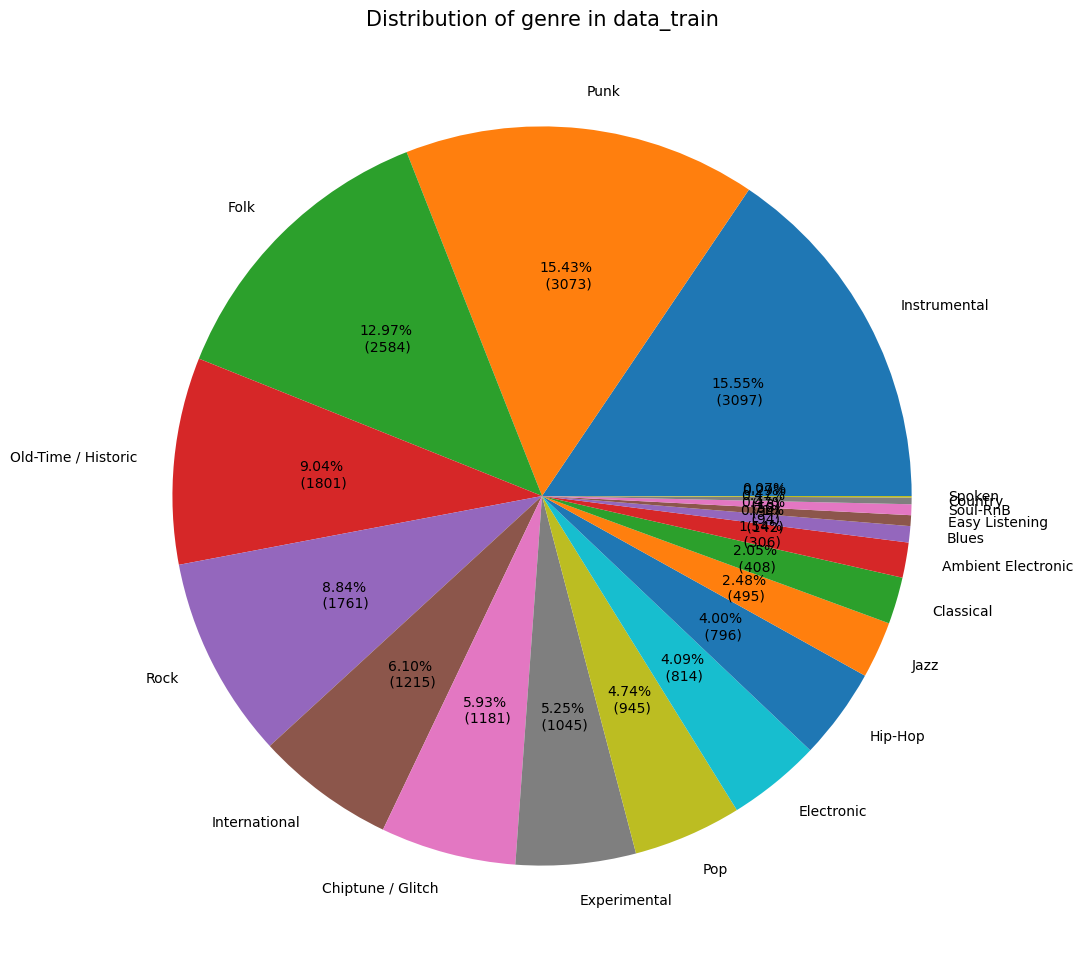

In [67]:
absolute_values = data_train['genre'].value_counts()
relative_values = data_train['genre'].value_counts(ascending=False, normalize=True).values * 100
bar_labels = [f'{values[0]}\n ({values[1]:.0f}%)' for values in zip(absolute_values, relative_values)]

plt.subplots(figsize=(15, 12))
ax = sns.barplot(x=data_train['genre'].value_counts().index, 
                 y=data_train['genre'].value_counts(), errorbar=None)
ax.bar_label(ax.containers[0], 
             fontsize=10, 
             labels=bar_labels)
plt.xticks(rotation='vertical')
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of genre in data_train', fontsize=15)
plt.show()


plt.subplots(figsize=(15, 12))
plt.pie(x=data_train['genre'].value_counts(), 
        labels=data_train['genre'].unique(), 
        autopct= lambda value: '{:.2f}%\n ({:.0f})'.format(value,(value/100)*absolute_values.sum()))
plt.title('Distribution of genre in data_train', fontsize=15)
plt.show()

#### PLOTTING WAVE FILE OF EXAMPLE FILE TO VISUALIZE CONCEPT

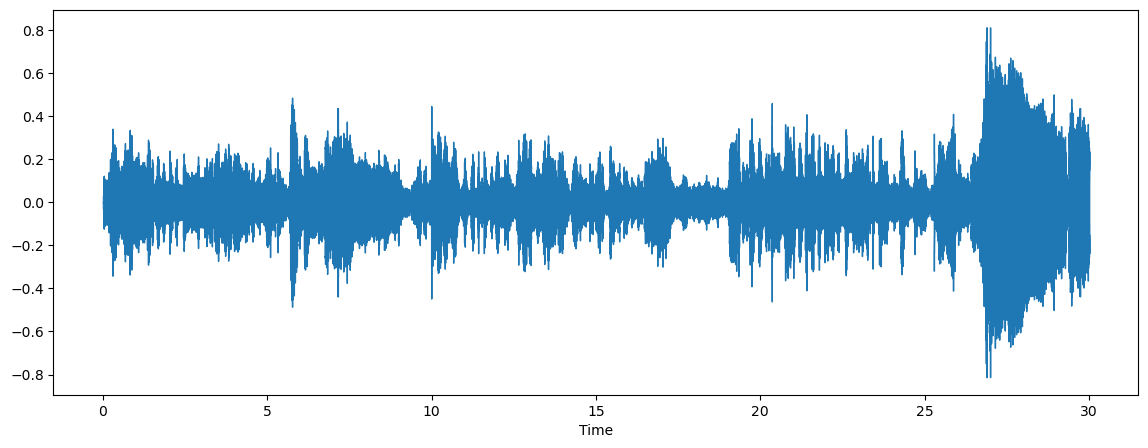

In [68]:
filename='train/010150.ogg'

plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

#### DEFINING FILE PATHS FOR FURTHER TRANSFORMATION

In [69]:
audio_dataset_path='train/'
metadata=pd.read_csv('C:/Users/Uzytkownik/Desktop/Kaggle competitions/Music Classification/train.csv')
metadata.head()

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock


#### DEFINING FEATURE EXTRACTOR FUNCTION

In [70]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

#### ITERATION THROUGH EVERY AUDIO FILE AND EXTRACTION FEATURES USING MEL-FREQUENCY CEPSTRAL COEFFICIENTS

In [71]:
extracted_features=[]

for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["filename"]))
    final_class_labels=row['genre']
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

241it [04:10,  1.04s/it]


KeyboardInterrupt: 

#### PRINTING EXTRACTED FEATURES TOGETHER WITH CLASS FEATURE

In [72]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.tail()

,feature,class
236,"[-276.5051, 164.19836, 14.390643, -19.308931, ...",Instrumental
237,"[-161.06206, 128.65456, 6.9189463, 51.02058, 9...",Instrumental
238,"[-103.26718, 138.89983, 4.9476104, 32.44163, 6...",Folk
239,"[-41.371315, 118.587204, -5.0569806, 23.97971,...",Electronic
240,"[-103.29944, 110.35184, 29.076263, 40.52121, 0...",Hip-Hop


#### DEFINING X AND Y DATASET

In [73]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

#### TRANSFORMING Y DATASET TO CATEGORICAL FORM

In [74]:
labelencoder=LabelEncoder()

y=to_categorical(labelencoder.fit_transform(y))

#### SPLITTING X AND Y DATASETS

In [75]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

#### DEFINING OUTPUT ARTIFICIAL NEURAL NETWORK LAYER SHAPE

In [76]:
num_labels=y.shape[1]

#### BUILDING ARTIFICIAL NEURAL NETWORK

In [77]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

#### FITTING NEURAL NETWORK TO DATA AND PRINTING ACCURACY SCORE FOR TRAIN AND TEST DATA

In [78]:
num_epochs = 1000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1000
6/6 [==============================] - ETA: 0s - loss: 50.3898 - accuracy: 0.0729 
Epoch 1: val_loss improved from inf to 10.22361, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 3s 131ms/step - loss: 50.3898 - accuracy: 0.0729 - val_loss: 10.2236 - val_accuracy: 0.0204
Epoch 2/1000
4/6 [===================>..........] - ETA: 0s - loss: 31.1667 - accuracy: 0.0703
Epoch 2: val_loss improved from 10.22361 to 6.30598, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 0s 46ms/step - loss: 32.2182 - accuracy: 0.0781 - val_loss: 6.3060 - val_accuracy: 0.0612
Epoch 3/1000
5/6 [========================>.....] - ETA: 0s - loss: 23.8255 - accuracy: 0.0750
Epoch 3: val_loss improved from 6.30598 to 4.24325, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 0s 42ms/step - loss: 24.0075 - accuracy: 0.0729 - val_loss: 4.2432 - val_accuracy: 0.1429
Epoch 

4/6 [===================>..........] - ETA: 0s - loss: 3.5099 - accuracy: 0.1484
Epoch 29: val_loss did not improve from 2.53782
6/6 [==============================] - 0s 30ms/step - loss: 3.6311 - accuracy: 0.1615 - val_loss: 2.7023 - val_accuracy: 0.2041
Epoch 30/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.9386 - accuracy: 0.1250
Epoch 30: val_loss did not improve from 2.53782
6/6 [==============================] - 0s 21ms/step - loss: 3.2317 - accuracy: 0.1146 - val_loss: 2.6989 - val_accuracy: 0.2041
Epoch 31/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.5584 - accuracy: 0.1875
Epoch 31: val_loss did not improve from 2.53782
6/6 [==============================] - 0s 25ms/step - loss: 3.3002 - accuracy: 0.1146 - val_loss: 2.6971 - val_accuracy: 0.2041
Epoch 32/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.3779 - accuracy: 0.1250
Epoch 32: val_loss did not improve from 2.53782
6/6 [==============================] - 0s 21ms/step - loss

1/6 [====>.........................] - ETA: 0s - loss: 2.8743 - accuracy: 0.1875
Epoch 59: val_loss did not improve from 2.53782
6/6 [==============================] - 0s 21ms/step - loss: 2.8632 - accuracy: 0.1823 - val_loss: 2.6226 - val_accuracy: 0.2449
Epoch 60/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.1940 - accuracy: 0.2500
Epoch 60: val_loss did not improve from 2.53782
6/6 [==============================] - 0s 20ms/step - loss: 2.8107 - accuracy: 0.2083 - val_loss: 2.6183 - val_accuracy: 0.2449
Epoch 61/1000
5/6 [========================>.....] - ETA: 0s - loss: 2.7810 - accuracy: 0.2250
Epoch 61: val_loss did not improve from 2.53782
6/6 [==============================] - 0s 29ms/step - loss: 2.7756 - accuracy: 0.2240 - val_loss: 2.6145 - val_accuracy: 0.2449
Epoch 62/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.5321 - accuracy: 0.1250
Epoch 62: val_loss did not improve from 2.53782
6/6 [==============================] - 0s 22ms/step - loss

6/6 [==============================] - ETA: 0s - loss: 2.6023 - accuracy: 0.1979
Epoch 87: val_loss did not improve from 2.47849
6/6 [==============================] - 0s 30ms/step - loss: 2.6023 - accuracy: 0.1979 - val_loss: 2.4787 - val_accuracy: 0.2857
Epoch 88/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.8502 - accuracy: 0.1250
Epoch 88: val_loss did not improve from 2.47849
6/6 [==============================] - 0s 18ms/step - loss: 2.5884 - accuracy: 0.2031 - val_loss: 2.4796 - val_accuracy: 0.2449
Epoch 89/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.3775 - accuracy: 0.1562
Epoch 89: val_loss did not improve from 2.47849
6/6 [==============================] - 0s 25ms/step - loss: 2.6335 - accuracy: 0.2240 - val_loss: 2.4799 - val_accuracy: 0.2449
Epoch 90/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.6319 - accuracy: 0.1875
Epoch 90: val_loss improved from 2.47849 to 2.47527, saving model to saved_models\audio_classification.hdf

Epoch 113/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.2462 - accuracy: 0.4688
Epoch 113: val_loss improved from 2.37412 to 2.36568, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 0s 35ms/step - loss: 2.5265 - accuracy: 0.2500 - val_loss: 2.3657 - val_accuracy: 0.2857
Epoch 114/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.2915 - accuracy: 0.2812
Epoch 114: val_loss improved from 2.36568 to 2.35451, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 0s 36ms/step - loss: 2.6178 - accuracy: 0.2344 - val_loss: 2.3545 - val_accuracy: 0.2857
Epoch 115/1000
5/6 [========================>.....] - ETA: 0s - loss: 2.5749 - accuracy: 0.2313
Epoch 115: val_loss did not improve from 2.35451
6/6 [==============================] - 0s 41ms/step - loss: 2.5331 - accuracy: 0.2448 - val_loss: 2.3586 - val_accuracy: 0.2857
Epoch 116/1000
5/6 [========================>.....] - ETA: 0s

6/6 [==============================] - 0s 35ms/step - loss: 2.4387 - accuracy: 0.2240 - val_loss: 2.2246 - val_accuracy: 0.3265
Epoch 140/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.8647 - accuracy: 0.2812
Epoch 140: val_loss improved from 2.22457 to 2.22211, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 0s 29ms/step - loss: 2.5006 - accuracy: 0.2344 - val_loss: 2.2221 - val_accuracy: 0.3265
Epoch 141/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.1157 - accuracy: 0.3438
Epoch 141: val_loss improved from 2.22211 to 2.21764, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 0s 30ms/step - loss: 2.4666 - accuracy: 0.2292 - val_loss: 2.2176 - val_accuracy: 0.3469
Epoch 142/1000
6/6 [==============================] - ETA: 0s - loss: 2.4556 - accuracy: 0.2188
Epoch 142: val_loss did not improve from 2.21764
6/6 [==============================] - 0s 89ms/step - loss: 2

Epoch 168/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.6074 - accuracy: 0.2500
Epoch 168: val_loss did not improve from 2.17740
6/6 [==============================] - 0s 18ms/step - loss: 2.3897 - accuracy: 0.2552 - val_loss: 2.1939 - val_accuracy: 0.3673
Epoch 169/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.4420 - accuracy: 0.1875
Epoch 169: val_loss did not improve from 2.17740
6/6 [==============================] - 0s 44ms/step - loss: 2.3302 - accuracy: 0.2656 - val_loss: 2.1918 - val_accuracy: 0.3673
Epoch 170/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.5551 - accuracy: 0.1250
Epoch 170: val_loss did not improve from 2.17740
6/6 [==============================] - 0s 22ms/step - loss: 2.3902 - accuracy: 0.2500 - val_loss: 2.2011 - val_accuracy: 0.3673
Epoch 171/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.3800 - accuracy: 0.1875
Epoch 171: val_loss did not improve from 2.17740
6/6 [==============================]

Epoch 196/1000
6/6 [==============================] - ETA: 0s - loss: 2.3756 - accuracy: 0.2344
Epoch 196: val_loss did not improve from 2.10207
6/6 [==============================] - 0s 39ms/step - loss: 2.3756 - accuracy: 0.2344 - val_loss: 2.1098 - val_accuracy: 0.3673
Epoch 197/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.5587 - accuracy: 0.1250
Epoch 197: val_loss did not improve from 2.10207
6/6 [==============================] - 0s 65ms/step - loss: 2.3525 - accuracy: 0.2396 - val_loss: 2.1185 - val_accuracy: 0.3469
Epoch 198/1000
6/6 [==============================] - ETA: 0s - loss: 2.3250 - accuracy: 0.3073
Epoch 198: val_loss did not improve from 2.10207
6/6 [==============================] - 0s 57ms/step - loss: 2.3250 - accuracy: 0.3073 - val_loss: 2.1114 - val_accuracy: 0.3673
Epoch 199/1000
6/6 [==============================] - ETA: 0s - loss: 2.2840 - accuracy: 0.2500
Epoch 199: val_loss did not improve from 2.10207
6/6 [==============================]

Epoch 224/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.2199 - accuracy: 0.2812
Epoch 224: val_loss did not improve from 2.06258
6/6 [==============================] - 0s 17ms/step - loss: 2.2739 - accuracy: 0.2552 - val_loss: 2.0760 - val_accuracy: 0.3673
Epoch 225/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.2820 - accuracy: 0.2188
Epoch 225: val_loss did not improve from 2.06258
6/6 [==============================] - 0s 38ms/step - loss: 2.2263 - accuracy: 0.2708 - val_loss: 2.0702 - val_accuracy: 0.3673
Epoch 226/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.3528 - accuracy: 0.3750
Epoch 226: val_loss did not improve from 2.06258
6/6 [==============================] - 0s 22ms/step - loss: 2.2470 - accuracy: 0.2708 - val_loss: 2.0702 - val_accuracy: 0.3673
Epoch 227/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.0190 - accuracy: 0.4375
Epoch 227: val_loss did not improve from 2.06258
6/6 [==============================]

Epoch 253/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.2896 - accuracy: 0.2812
Epoch 253: val_loss improved from 2.03265 to 2.03221, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 0s 86ms/step - loss: 2.1329 - accuracy: 0.3125 - val_loss: 2.0322 - val_accuracy: 0.4082
Epoch 254/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.3471 - accuracy: 0.1562
Epoch 254: val_loss did not improve from 2.03221
6/6 [==============================] - 0s 25ms/step - loss: 2.1383 - accuracy: 0.2865 - val_loss: 2.0355 - val_accuracy: 0.4082
Epoch 255/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.9647 - accuracy: 0.3125
Epoch 255: val_loss improved from 2.03221 to 2.02887, saving model to saved_models\audio_classification.hdf5
6/6 [==============================] - 0s 92ms/step - loss: 2.1044 - accuracy: 0.2760 - val_loss: 2.0289 - val_accuracy: 0.4082
Epoch 256/1000
1/6 [====>.........................] - ETA: 0s

1/6 [====>.........................] - ETA: 0s - loss: 2.1448 - accuracy: 0.3438
Epoch 281: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 2.0348 - accuracy: 0.2917 - val_loss: 2.0138 - val_accuracy: 0.3673
Epoch 282/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.1189 - accuracy: 0.3125
Epoch 282: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 2.0451 - accuracy: 0.2969 - val_loss: 2.0134 - val_accuracy: 0.3673
Epoch 283/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.0510 - accuracy: 0.4062
Epoch 283: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 2.1781 - accuracy: 0.2604 - val_loss: 2.0206 - val_accuracy: 0.3878
Epoch 284/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.7115 - accuracy: 0.3438
Epoch 284: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 17ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.7025 - accuracy: 0.3438
Epoch 311: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 1.9279 - accuracy: 0.3385 - val_loss: 2.0625 - val_accuracy: 0.3878
Epoch 312/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.9322 - accuracy: 0.3750
Epoch 312: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 1.9798 - accuracy: 0.3073 - val_loss: 2.0533 - val_accuracy: 0.3878
Epoch 313/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.7022 - accuracy: 0.5000
Epoch 313: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 1.9750 - accuracy: 0.2917 - val_loss: 2.0644 - val_accuracy: 0.3878
Epoch 314/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.1989 - accuracy: 0.2812
Epoch 314: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.8026 - accuracy: 0.3750
Epoch 341: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 20ms/step - loss: 1.9389 - accuracy: 0.3385 - val_loss: 2.0844 - val_accuracy: 0.3469
Epoch 342/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.0229 - accuracy: 0.3438
Epoch 342: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 1.9372 - accuracy: 0.3229 - val_loss: 2.0950 - val_accuracy: 0.3469
Epoch 343/1000
3/6 [==============>...............] - ETA: 0s - loss: 1.8964 - accuracy: 0.3021
Epoch 343: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 29ms/step - loss: 1.8831 - accuracy: 0.3125 - val_loss: 2.0901 - val_accuracy: 0.3673
Epoch 344/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.7761 - accuracy: 0.3438
Epoch 344: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 17ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.9105 - accuracy: 0.2500
Epoch 371: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 1.8278 - accuracy: 0.3021 - val_loss: 2.1700 - val_accuracy: 0.3673
Epoch 372/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.8804 - accuracy: 0.3125
Epoch 372: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 1.9025 - accuracy: 0.3177 - val_loss: 2.1565 - val_accuracy: 0.3673
Epoch 373/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.8154 - accuracy: 0.3438
Epoch 373: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 1.8977 - accuracy: 0.3229 - val_loss: 2.1025 - val_accuracy: 0.3673
Epoch 374/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.0055 - accuracy: 0.3125
Epoch 374: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step

1/6 [====>.........................] - ETA: 0s - loss: 2.0755 - accuracy: 0.2188
Epoch 401: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 1.7916 - accuracy: 0.3490 - val_loss: 2.2324 - val_accuracy: 0.3673
Epoch 402/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.7807 - accuracy: 0.3750
Epoch 402: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 21ms/step - loss: 1.6496 - accuracy: 0.4010 - val_loss: 2.1940 - val_accuracy: 0.3469
Epoch 403/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.7900 - accuracy: 0.2812
Epoch 403: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 1.6813 - accuracy: 0.3698 - val_loss: 2.1747 - val_accuracy: 0.3673
Epoch 404/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.9705 - accuracy: 0.2812
Epoch 404: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.2991 - accuracy: 0.5625
Epoch 431: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 1.6112 - accuracy: 0.4479 - val_loss: 2.1852 - val_accuracy: 0.3469
Epoch 432/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.5699 - accuracy: 0.2812
Epoch 432: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 28ms/step - loss: 1.6590 - accuracy: 0.3542 - val_loss: 2.1971 - val_accuracy: 0.3673
Epoch 433/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.7229 - accuracy: 0.3750
Epoch 433: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 27ms/step - loss: 1.6321 - accuracy: 0.4375 - val_loss: 2.2474 - val_accuracy: 0.3265
Epoch 434/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.6308 - accuracy: 0.4375
Epoch 434: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 21ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.8787 - accuracy: 0.3750
Epoch 461: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 1.5604 - accuracy: 0.4219 - val_loss: 2.3139 - val_accuracy: 0.3469
Epoch 462/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.4173 - accuracy: 0.4688
Epoch 462: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 1.5514 - accuracy: 0.4427 - val_loss: 2.3113 - val_accuracy: 0.3469
Epoch 463/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.5580 - accuracy: 0.3750
Epoch 463: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 14ms/step - loss: 1.4690 - accuracy: 0.4271 - val_loss: 2.3142 - val_accuracy: 0.3265
Epoch 464/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.4074 - accuracy: 0.3750
Epoch 464: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.3731 - accuracy: 0.4375
Epoch 491: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 31ms/step - loss: 1.4482 - accuracy: 0.4948 - val_loss: 2.4591 - val_accuracy: 0.3673
Epoch 492/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.4719 - accuracy: 0.4062
Epoch 492: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 21ms/step - loss: 1.4681 - accuracy: 0.4740 - val_loss: 2.4543 - val_accuracy: 0.3673
Epoch 493/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.4159 - accuracy: 0.5938
Epoch 493: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 42ms/step - loss: 1.3436 - accuracy: 0.5260 - val_loss: 2.4534 - val_accuracy: 0.3469
Epoch 494/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.3506 - accuracy: 0.4062
Epoch 494: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 20ms/step

6/6 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.5260
Epoch 521: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 27ms/step - loss: 1.3637 - accuracy: 0.5260 - val_loss: 2.6608 - val_accuracy: 0.3469
Epoch 522/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.3146 - accuracy: 0.6250
Epoch 522: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 20ms/step - loss: 1.3340 - accuracy: 0.5052 - val_loss: 2.6677 - val_accuracy: 0.3673
Epoch 523/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.4249 - accuracy: 0.4688
Epoch 523: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 21ms/step - loss: 1.3879 - accuracy: 0.4948 - val_loss: 2.7219 - val_accuracy: 0.3469
Epoch 524/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.3284 - accuracy: 0.5938
Epoch 524: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 23ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.3324 - accuracy: 0.6250
Epoch 551: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 1.3523 - accuracy: 0.5625 - val_loss: 2.6999 - val_accuracy: 0.3469
Epoch 552/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.5520 - accuracy: 0.4375
Epoch 552: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 1.2111 - accuracy: 0.5469 - val_loss: 2.7040 - val_accuracy: 0.3265
Epoch 553/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.3163 - accuracy: 0.6250
Epoch 553: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 1.2569 - accuracy: 0.5521 - val_loss: 2.7435 - val_accuracy: 0.3469
Epoch 554/1000
6/6 [==============================] - ETA: 0s - loss: 1.3954 - accuracy: 0.5104
Epoch 554: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 46ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.8010 - accuracy: 0.7188
Epoch 581: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 29ms/step - loss: 1.1458 - accuracy: 0.6302 - val_loss: 2.9204 - val_accuracy: 0.3469
Epoch 582/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8399 - accuracy: 0.6875
Epoch 582: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 24ms/step - loss: 1.1900 - accuracy: 0.5885 - val_loss: 2.9646 - val_accuracy: 0.3673
Epoch 583/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.1704 - accuracy: 0.5625
Epoch 583: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 35ms/step - loss: 1.3157 - accuracy: 0.5260 - val_loss: 2.9638 - val_accuracy: 0.3265
Epoch 584/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.1218 - accuracy: 0.6250
Epoch 584: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 38ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.9685 - accuracy: 0.6250
Epoch 611: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 21ms/step - loss: 1.0974 - accuracy: 0.6354 - val_loss: 3.1808 - val_accuracy: 0.2653
Epoch 612/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.2245 - accuracy: 0.5625
Epoch 612: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 20ms/step - loss: 1.0635 - accuracy: 0.6510 - val_loss: 3.1853 - val_accuracy: 0.2653
Epoch 613/1000
6/6 [==============================] - ETA: 0s - loss: 1.1184 - accuracy: 0.5677
Epoch 613: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 29ms/step - loss: 1.1184 - accuracy: 0.5677 - val_loss: 3.2026 - val_accuracy: 0.2449
Epoch 614/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.0000 - accuracy: 0.5938
Epoch 614: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 21ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.9470 - accuracy: 0.7188
Epoch 641: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 23ms/step - loss: 1.0462 - accuracy: 0.6042 - val_loss: 3.1814 - val_accuracy: 0.3265
Epoch 642/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.0390 - accuracy: 0.6562
Epoch 642: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 21ms/step - loss: 1.1332 - accuracy: 0.5833 - val_loss: 3.1681 - val_accuracy: 0.2857
Epoch 643/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.1257 - accuracy: 0.6250
Epoch 643: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 1.1137 - accuracy: 0.6094 - val_loss: 3.1499 - val_accuracy: 0.2857
Epoch 644/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.2483 - accuracy: 0.6250
Epoch 644: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 23ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.0417 - accuracy: 0.7188
Epoch 671: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 0.8807 - accuracy: 0.6927 - val_loss: 3.4148 - val_accuracy: 0.3061
Epoch 672/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.3410 - accuracy: 0.5312
Epoch 672: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 1.0387 - accuracy: 0.6354 - val_loss: 3.4814 - val_accuracy: 0.3061
Epoch 673/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.9977 - accuracy: 0.6250
Epoch 673: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 1.0204 - accuracy: 0.6510 - val_loss: 3.5513 - val_accuracy: 0.3265
Epoch 674/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.9995 - accuracy: 0.6250
Epoch 674: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.0287 - accuracy: 0.6562
Epoch 701: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 1.0139 - accuracy: 0.6042 - val_loss: 3.6103 - val_accuracy: 0.2653
Epoch 702/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.9459 - accuracy: 0.6562
Epoch 702: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 0.9326 - accuracy: 0.6667 - val_loss: 3.5808 - val_accuracy: 0.3061
Epoch 703/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8151 - accuracy: 0.7500
Epoch 703: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 1.0112 - accuracy: 0.6146 - val_loss: 3.6611 - val_accuracy: 0.3061
Epoch 704/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8841 - accuracy: 0.6250
Epoch 704: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.7507 - accuracy: 0.7188
Epoch 731: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 0.8809 - accuracy: 0.6875 - val_loss: 3.8370 - val_accuracy: 0.3265
Epoch 732/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.0239 - accuracy: 0.7188
Epoch 732: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 0.9500 - accuracy: 0.6771 - val_loss: 3.8775 - val_accuracy: 0.3265
Epoch 733/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.0206 - accuracy: 0.5938
Epoch 733: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 0.9945 - accuracy: 0.6354 - val_loss: 3.8912 - val_accuracy: 0.3265
Epoch 734/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.7900 - accuracy: 0.7812
Epoch 734: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.9611 - accuracy: 0.7500
Epoch 761: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 1.0483 - accuracy: 0.6615 - val_loss: 3.9045 - val_accuracy: 0.3061
Epoch 762/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8297 - accuracy: 0.7188
Epoch 762: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 20ms/step - loss: 0.8334 - accuracy: 0.6771 - val_loss: 3.8516 - val_accuracy: 0.3061
Epoch 763/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.9147 - accuracy: 0.7188
Epoch 763: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 0.7921 - accuracy: 0.7552 - val_loss: 3.8508 - val_accuracy: 0.3061
Epoch 764/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.1509 - accuracy: 0.5000
Epoch 764: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.9546 - accuracy: 0.7188
Epoch 791: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.9024 - accuracy: 0.6562 - val_loss: 3.9168 - val_accuracy: 0.3061
Epoch 792/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.7681 - accuracy: 0.7188
Epoch 792: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step - loss: 0.8694 - accuracy: 0.7083 - val_loss: 3.9953 - val_accuracy: 0.2857
Epoch 793/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.7015 - accuracy: 0.7812
Epoch 793: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 0.9458 - accuracy: 0.7083 - val_loss: 4.0097 - val_accuracy: 0.2449
Epoch 794/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.7666 - accuracy: 0.7500
Epoch 794: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.6738 - accuracy: 0.7812
Epoch 821: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.8460 - accuracy: 0.6927 - val_loss: 4.0401 - val_accuracy: 0.2449
Epoch 822/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.9022 - accuracy: 0.7500
Epoch 822: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 0.8437 - accuracy: 0.7240 - val_loss: 4.0354 - val_accuracy: 0.2857
Epoch 823/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.0655 - accuracy: 0.5312
Epoch 823: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 15ms/step - loss: 0.8533 - accuracy: 0.6667 - val_loss: 4.0685 - val_accuracy: 0.2653
Epoch 824/1000
6/6 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.7917
Epoch 824: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 58ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.0198 - accuracy: 0.6562
Epoch 851: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.8034 - accuracy: 0.7083 - val_loss: 4.2260 - val_accuracy: 0.2653
Epoch 852/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.0231 - accuracy: 0.5938
Epoch 852: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.8385 - accuracy: 0.7083 - val_loss: 4.2886 - val_accuracy: 0.2857
Epoch 853/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8232 - accuracy: 0.7188
Epoch 853: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 12ms/step - loss: 0.7903 - accuracy: 0.7083 - val_loss: 4.4052 - val_accuracy: 0.2653
Epoch 854/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.1958 - accuracy: 0.6250
Epoch 854: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 17ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.6036 - accuracy: 0.7812
Epoch 881: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 0.8470 - accuracy: 0.7396 - val_loss: 4.5777 - val_accuracy: 0.2857
Epoch 882/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8986 - accuracy: 0.7188
Epoch 882: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 0.8229 - accuracy: 0.7188 - val_loss: 4.5853 - val_accuracy: 0.2449
Epoch 883/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.9190 - accuracy: 0.6562
Epoch 883: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 18ms/step - loss: 0.7881 - accuracy: 0.7292 - val_loss: 4.4528 - val_accuracy: 0.2653
Epoch 884/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.5307 - accuracy: 0.8438
Epoch 884: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 20ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.5162 - accuracy: 0.8750
Epoch 911: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.6892 - accuracy: 0.7396 - val_loss: 4.4693 - val_accuracy: 0.2449
Epoch 912/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.6163 - accuracy: 0.7500
Epoch 912: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 33ms/step - loss: 0.7655 - accuracy: 0.7552 - val_loss: 4.4623 - val_accuracy: 0.2653
Epoch 913/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.7852 - accuracy: 0.6562
Epoch 913: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 54ms/step - loss: 0.7237 - accuracy: 0.7656 - val_loss: 4.4300 - val_accuracy: 0.2653
Epoch 914/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.6703 - accuracy: 0.8125
Epoch 914: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 20ms/step

1/6 [====>.........................] - ETA: 0s - loss: 1.0919 - accuracy: 0.5938
Epoch 941: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.7327 - accuracy: 0.7500 - val_loss: 4.6295 - val_accuracy: 0.2449
Epoch 942/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8458 - accuracy: 0.6250
Epoch 942: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.7260 - accuracy: 0.7292 - val_loss: 4.6037 - val_accuracy: 0.2245
Epoch 943/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.1424 - accuracy: 0.7812
Epoch 943: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.8566 - accuracy: 0.7083 - val_loss: 4.5782 - val_accuracy: 0.2245
Epoch 944/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.5460 - accuracy: 0.7812
Epoch 944: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step

1/6 [====>.........................] - ETA: 0s - loss: 0.5725 - accuracy: 0.7500
Epoch 971: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 16ms/step - loss: 0.6085 - accuracy: 0.7656 - val_loss: 5.0823 - val_accuracy: 0.2041
Epoch 972/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8203 - accuracy: 0.7188
Epoch 972: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 22ms/step - loss: 0.7848 - accuracy: 0.7812 - val_loss: 5.0868 - val_accuracy: 0.2041
Epoch 973/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.8330 - accuracy: 0.8125
Epoch 973: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 41ms/step - loss: 0.7615 - accuracy: 0.7708 - val_loss: 4.8867 - val_accuracy: 0.2245
Epoch 974/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.2456 - accuracy: 0.7812
Epoch 974: val_loss did not improve from 1.99654
6/6 [==============================] - 0s 19ms/step